# Performance analysis of GLUE and other schemes

In [1]:
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
import tikzplotlib
# set to true if you want to save the figures as tikzplots, false if you don't
maketikzplot = True
# set to true if you want to save the figures as jpgs, false if you don't
makejpgplot = False
# leave the following false
nonregular = False

Setting up variables and functions for converting cycles to ms. 

In [2]:
cyclesperms = 1600000
def convert_cycles_to_ms(x):
    return x/cyclesperms

def ms_round(x):
    return float(round(Decimal(convert_cycles_to_ms(x)),1))

def bitstokb(x):
    return float(round(Decimal(x/(8*1024)),2))

Setting up the sizes of the elements in the BLS12-446 curve groups (in bits).

In [3]:
G1size = np.ceil(381/8)*8
G2size = 2*G1size+8
Gtsize = 12*G1size
Zpsize = np.ceil(255/8)*8

Initiating operational costs of the group operations.

In [4]:
# group G
g1_add = 5227
g1_mul = 926115
g1_mul_fix = 485298
g1_mul_sim = 1242825
g1_mul_onemore = 316710
g1_map = 1163404

# group H
g2_add = 12012
g2_mul = 2076002 
g2_mul_fix = 945323
g2_mul_sim = 3459757
g2_mul_onemore = 1383755
g2_map = 2932564

# group Gt
gt_exp = 3101130

# pairing operations
pair = 6259415
pair_one_more = 1462317

Function for multi-exponentiations, which may be faster than simply computing the product of multiple exponentiations. If using fixed-base exponentiations are faster, it uses those.

In [5]:
def multiexp(x):
    fix = x*g1_mul_fix
    if x > 1:
        sim = g1_mul_sim+(x-2)*g1_mul_onemore
    else:
        sim = g1_mul_fix
    if fix < sim:
        return fix
    else: 
        return sim
    
def multiexpg2(x):
    fix = x*g2_mul_fix
    if x > 1:
        sim = g2_mul_sim+(x-2)*g2_mul_onemore
    else:
        sim = g2_mul_fix
    if fix < sim:
        return fix
    else: 
        return sim

If we consider full security, then we multiply all source-group elements (i.e., those in G or H) by two. Set to 1 to obtain costs for the selectively secure variants.

In [6]:
security = 2

**GLUE (for MSPs only, regular and online/offline)**

*Storage costs*

In [7]:
# regular
def pubkeysizeGLUE(n_k,n_c):
    gh = G1size + G2size
    Bs = G1size*(1+n_c + n_k+n_c)
    return Gtsize + security*(gh + Bs)    
    
def keysizeGLUE(n_k,n_c,atts):
    k = G2size
    kp = G2size
    k1att = atts*G2size
    k2l = np.ceil(atts/n_k)*G2size
    return security*(k + kp + k1att + k2l)

def ciphertextsizeGLUE(n_k,n_c,atts):
    cp = G1size
    c1 = atts*G1size
    c2 = atts*G1size
    c3 = np.ceil(atts/n_c)*G1size
    return Gtsize + security *(cp + c1 + c2 + c3)

# online/offline
def keysizeGLUEOO(n_k,n_c,atts):
    knormal = keysizeGLUE(n_k,n_c,atts)
    kextra = atts*Zpsize
    return knormal + kextra

def ciphertextsizeGLUEOO(n_k,n_c,atts):
    cnormal = ciphertextsizeGLUE(n_k,n_c,atts)
    cextra = atts*(n_k+n_c)*Zpsize
    return cnormal + cextra

*Computational costs*

In [8]:
# regular
def keycostGLUE(n_k,n_c,atts):
    k = g2_mul_fix
    kp = g2_mul_fix
    k1att = atts*g2_mul_fix
    k2l = np.ceil(atts/n_k)*g2_mul_fix
    return security*(k + kp + k1att + k2l)

def enccostGLUE(n_k,n_c,atts):
    cp = g1_mul_fix
    c1 = atts*multiexp(n_c+1)
    c2 = atts*multiexp(n_k + n_c)
    c3 = np.ceil(atts/n_c)*g1_mul_fix
    return gt_exp + security*(cp + c1 + c2 + c3)

def deccostGLUE(n_k,n_c,atts):
    nrpairings = (np.ceil(atts/n_k) + np.ceil(atts/n_c))
    paircosts = ((pair + nrpairings * pair_one_more) + pair_one_more)
    return security*paircosts

# online/offline (decryption only)
def deccostGLUEOO(n_k,n_c,atts):
    nrpairings = (np.ceil(atts/n_k) + np.ceil(atts/n_c))
    paircosts = ((pair + nrpairings * pair_one_more) + pair_one_more)
    c1cost = multiexp(n_c)
    c3cost = multiexp(np.ceil((n_k+n_c-1)*atts/n_k))
    return security*(paircosts + c1cost + c3cost)

**GLUE-N (regular and online/offline)**

*Storage costs*

In [9]:
# regular
def pubkeysizeGLUENMSP(n_k,n_c):
    gh = G1size + G2size
    Bs = G1size*(1+n_c + n_k+n_c)
    return Gtsize + security*(gh + Bs)       

def keysizeGLUENMSP(n_k,n_c,atts):
    m = np.ceil(atts/n_k)
    k = (3+2*m+atts)*G2size
    kp = 3*G1size
    k1att = 2*atts*G1size
    k2l = m*G1size
    return security*(k + kp + k1att + k2l)

def ciphertextsizeGLUENMSP(n_k,n_c,atts):
    cp = G2size
    c1 = atts*G1size
    c2 = atts*G1size
    c3 = atts*G1size
    c4 = np.ceil(atts/n_c)*G2size
    return Gtsize + security*(cp + c1 + c2 + c3 + c4)

# online/offline
def keysizeGLUENMSPOO(n_k,n_c,atts):
    knormal = keysizeGLUENMSP(n_k,n_c,atts)
    kextra = 3*atts*Zpsize
    return knormal + kextra

def ciphertextsizeGLUENMSPOO(n_k,n_c,atts):
    cnormal = ciphertextsizeGLUENMSP(n_k,n_c,atts)
    cextra = atts*(n_k+n_c)*Zpsize
    return cnormal + cextra

*Computational costs*

In [10]:
# regular
def keycostGLUENMSP(n_k,n_c,atts,attsset):
    m = np.ceil(attsset/n_k)
    keycosts = (3 + 2*m + atts)*g2_mul_fix + (3+3*atts)*g1_mul_fix
    return security*keycosts

def enccostGLUENMSP(n_k,n_c,atts,negs,attsset):
    mp = np.ceil(atts/n_c)
    n = n_c + n_k - 1
    enccosts = (atts + mp + 1)*g2_mul_fix + atts*(g1_mul_sim + multiexp(n_c+1) + multiexp(n+1))
    return gt_exp + security*enccosts

def deccostGLUENMSP(n_k,n_c,atts,negs,attsset):
    m = np.ceil(attsset/n_k)
    mp = np.ceil(atts/n_c)
    mps = np.ceil(negs/n_c)
    mpsp = np.ceil((atts-negs)/n_k)
    mpnn = np.ceil((atts-negs)/n_c)
    if negs > 0:
        a = 1
    else:
        a = 0
    nr_pairs = (a*m + mp + mpsp + 4)
    nr_pairs_alt = a*(m + 2 * attsset) + mpnn + mpsp + 4
    if nr_pairs_alt < nr_pairs:
        nr_pairs = nr_pairs_alt
    deccosts = pair + nr_pairs*pair_one_more + a*mps*m*(2*n_k+n_c)*g1_mul
    return security*deccosts

# online/offline (decryption only)
def deccostGLUENMSPOO(n_k,n_c,atts,negs,attsset):
    c1cost = multiexp(2*n_c-1)
    c3cost = multiexp(2*np.ceil((n_k+n_c-1)*atts/n_k))
    return deccostGLUENMSP(n_k,n_c,atts,negs,attsset) + security*(c1cost + c3cost)

**AHM+16**

*Storage costs*

In [11]:
def pubkeysizeAHM16(n_k):
    return Gtsize + security*(G2size + (6 + n_k)*G1size)

def keysizeAHM16(n_k,atts):
    return security*(2*atts+4)*G2size

def ciphertextsizeAHM16(n_k,atts):
    return Gtsize + security*(3 + 3*atts + n_k*atts)*G1size   

*Computational costs*

In [12]:
def keycostAHM16(n_k,atts):
    mp = np.ceil(atts/n_k)
    return security*(4 + 2*mp)*g2_mul_fix
    
def enccostAMH16(n_k,atts):
    ccp = 2*g1_mul_fix + multiexp(2)
    c1j = atts*multiexp(2)
    c2j3j0 = 2*atts*g1_mul_fix
    c3ji = (n_k-1)*atts*multiexp(2)
    return gt_exp + security*(ccp + c1j + c2j3j0 + c3ji)

def deccostAHM16(n_k,atts):
    d6 = atts*multiexp(n_k)
    l1 = pair + 2*pair_one_more
    l2 = (2*np.ceil(atts/n_k) + 1)*pair_one_more
    return security*(d6 + l1 + l2)

**ABGW17**

*Storage costs*

In [13]:
def pubkeysizeABGW17():
    return Gtsize + security*(5*G1size+G2size)

def keysizeABGW17(atts):
    return security*(atts+2)*G2size

def ciphertextsizeABGW17(atts):
    return Gtsize + security*3*atts*G1size

*Computational costs*

In [14]:
def keycostABGW17(atts):
    return security*(2+atts)*g2_mul_fix

def enccostABGW17(atts):
    return gt_exp + security*(atts*(2*multiexp(2) + g1_mul_fix))

def deccostABGW17(atts):
    return security*(pair + (atts + 1)*pair_one_more)

Choosing settings for GLUE and AHM+16

In [15]:
GLUEsettings = [(3,3), (5,5), (10,5)]
n_k_ahm = 2

Returns appropriate function.

In [16]:
def determinefunc(scheme, cost, opt, extr, S):
    if scheme == 'GLUE' or scheme == 'RW13':
        if len(extr) < 2:
            print("Error, not enough arguments for extr")
            print(scheme, cost, opt, extr)
            n_k = 0
            n_c = 0
        else: 
            n_k = extr[0]
            n_c = extr[1]
        if cost == 'S':
            if opt == 'MPK':
                return lambda atts: pubkeysizeGLUE(n_k,n_c)
            if opt == 'SK':
                return lambda atts: keysizeGLUE(n_k,n_c,atts)
            if opt == 'CT':
                return lambda atts: ciphertextsizeGLUE(n_k,n_c,atts)
        if cost == 'C':
            if opt == 'KG':
                return lambda atts: keycostGLUE(n_k,n_c,atts)
            if opt == 'Enc':
                return lambda atts: enccostGLUE(n_k,n_c,atts)
            if opt == 'Dec':
                return lambda atts: deccostGLUE(n_k,n_c,atts)
    if scheme == 'GLUE-OO' or scheme == 'HW14':
        if len(extr) < 2:
            print("Error, not enough arguments for extr")
            print(scheme, cost, opt, extr)
            n_k = 0
            n_c = 0
        else: 
            n_k = extr[0]
            n_c = extr[1]
        if cost == 'S':
            if opt == 'MPK':
                return lambda atts: pubkeysizeGLUE(n_k,n_c)
            if opt == 'SK':
                return lambda atts: keysizeGLUEOO(n_k,n_c,atts)
            if opt == 'CT':
                return lambda atts: ciphertextsizeGLUEOO(n_k,n_c,atts)
        if cost == 'C':
            if opt == 'KG':
                return lambda atts: 0
            if opt == 'Enc':
                return lambda atts: 0
            if opt == 'Dec':
                return lambda atts:  deccostGLUEOO(n_k,n_c,atts)
    if scheme == 'GLUE-N' or scheme == 'Att19':
        if len(extr) < 2:
            print("Error, not enough arguments for extr")
            print(scheme, cost, opt, extr)
            n_k = 0
            n_c = 0
        else: 
            n_k = extr[0]
            n_c = extr[1]
        if cost == 'S':
            if opt == 'MPK':
                return lambda atts: pubkeysizeGLUENMSP(n_k,n_c)
            if opt == 'SK':
                return lambda atts: keysizeGLUENMSP(n_k,n_c,atts)
            if opt == 'CT':
                return lambda atts: ciphertextsizeGLUENMSP(n_k,n_c,atts)
        if cost == 'C':
            if opt == 'KG':
                return lambda atts: keycostGLUENMSP(n_k,n_c,atts,S)
            if opt == 'Enc':
                return lambda atts: enccostGLUENMSP(n_k,n_c,atts,atts,S)
            if opt == 'Dec':
                if negmode:
                    return lambda atts: deccostGLUENMSP(n_k,n_c,atts,atts,S)
                else:
                    return lambda atts: deccostGLUENMSP(n_k,n_c,atts,0,S)
    if scheme == 'GLUE-N-OO' or scheme == 'Att19-OO':
        if len(extr) < 2:
            print("Error, not enough arguments for extr")
            print(scheme, cost, opt, extr)
            n_k = 0
            n_c = 0
        else: 
            n_k = extr[0]
            n_c = extr[1]
        if cost == 'S':
            if opt == 'MPK':
                return lambda atts: pubkeysizeGLUENMSP(n_k,n_c)
            if opt == 'SK':
                return lambda atts: keysizeGLUENMSPOO(n_k,n_c,atts)
            if opt == 'CT':
                return lambda atts: ciphertextsizeGLUENMSPOO(n_k,n_c,atts)
        if cost == 'C':
            if opt == 'KG':
                return lambda atts: 0
            if opt == 'Enc':
                return lambda atts: 0
            if opt == 'Dec':
                if negmode:
                    return lambda atts: deccostGLUENMSPOO(n_k,n_c,atts,atts,S)
                else:
                    return lambda atts: deccostGLUENMSPOO(n_k,n_c,atts,0,S)
    if scheme == 'AHM+16':
        if cost == 'S':
            if opt == 'MPK':
                return lambda atts: pubkeysizeAHM16(n_k_ahm)
            if opt == 'SK':
                return lambda atts: keysizeAHM16(n_k_ahm,atts)
            if opt == 'CT':
                return lambda atts: ciphertextsizeAHM16(n_k_ahm,atts)
        if cost == 'C':
            if opt == 'KG':
                return lambda atts: keycostAHM16(n_k_ahm,atts)
            if opt == 'Enc':
                return lambda atts: enccostAMH16(n_k_ahm,atts)
            if opt == 'Dec':
                return lambda atts: deccostAHM16(n_k_ahm,atts)
    if scheme == 'ABGW17':
        if cost == 'S':
            if opt == 'MPK':
                return lambda atts: pubkeysizeABGW17
            if opt == 'SK':
                return lambda atts: keysizeABGW17(atts)
            if opt == 'CT':
                return lambda atts: ciphertextsizeABGW17(atts)
        if cost == 'C':
            if opt == 'KG':
                return lambda atts: keycostABGW17(atts)
            if opt == 'Enc':
                return lambda atts: enccostABGW17(atts)
            if opt == 'Dec':
                return lambda atts: deccostABGW17(atts)
    return lambda x: x
            
def determinelabels(cost, opt):
    if cost == 'S':
        ylab = 'Size in KB'
        if opt == 'SK':
            title = 'Key sizes'
            xlab = 'Size of the set of attributes'
        if opt == 'CT':
            title = 'Ciphertext sizes'
            xlab = 'Length of the policy'
    if cost == 'C':
        ylab = 'Time in ms'
        if opt == 'KG':
            title = 'Key generation costs'
            xlab = 'Size of the set of attributes'
        if opt == 'Enc':
            title = 'Encryption costs'
            xlab = 'Length of the policy'
        if opt == 'Dec':
            title = 'Decryption costs'
            xlab = 'Number of matching attributes'
    return (xlab,ylab,title)

def determineGLUEname():
    if modeg == 'regular':
        return 'GLUE'
    if modeg == 'OO':
        return 'GLUE-OO'
    if modeg == 'N':
        return 'GLUE-N'
    if modeg == 'N-OO':
        return 'GLUE-N-OO'

Settings and functions to plot everything.

In [17]:
maxsize = 101
listoplot1 = [('RW13', [1,1]), ('AHM+16',[0]), ('ABGW17',[0])]
listoplot2 = [('HW14', [1,1])]
listoplot3 = [('Att19', [1,1])]
listoplot4 = [('Att19-OO', [1,1])]

In [18]:
def plotcosts(cost, opt, lis, S):
    sizes = list(range(1,maxsize))
    nrmarks = len(lis) + len(GLUEsettings)
    markers = ["$" + str(i+1) + "$" for i in range(nrmarks)]
    plt.style.use("ggplot")
    
    if cost == 'C':
        rnd = ms_round
    else: 
        rnd = bitstokb
    
    c = 0
    for (x,y) in GLUEsettings:
        glue = []
        for z in sizes: 
            gluename = determineGLUEname()
            glue.append(rnd(determinefunc(gluename, cost, opt, [x,y], S)(z)))
        plt.plot(sizes, glue, label=gluename + '$_{(' + str(x) + ',' + str(y) + ')}$', marker=markers[c], markevery=(c*5,nrmarks*5))
        c += 1
    
    for (scheme, extr) in lis:
        sch = []
        for z in sizes:
            sch.append(rnd(determinefunc(scheme, cost, opt, extr, S)(z)))
        plt.plot(sizes, sch, label=scheme, marker=markers[c], markevery=(c*5,nrmarks*5))
        c += 1
    
    (xlab,ylab,title) = determinelabels(cost, opt)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend()
    
    pref = opt + "-" + modeg
    if negmode:
        pref += "-N" + str(S)
    if nonregular:
        pref += suffix
    
    if maketikzplot:
        tikzplotlib.save(pref + ".tex")
    if makejpgplot:
        plt.savefig(pref + ".jpg")
    
    plt.show()
    plt.close()

In [19]:
def setmode(mode, nmode, Smode):
    global listoplot, S, negmode, modeg
    modeg = mode
    S = Smode
    if mode == 'regular':
        negmode = False
        listoplot = listoplot1
    if mode == 'OO':
        negmode = False
        listoplot = listoplot2
    if mode == 'N':
        negmode = nmode
        listoplot = listoplot3
    if mode == 'N-OO':
        negmode = nmode
        listoplot = listoplot4

def SKcosts():
    plotcosts('S', 'SK', listoplot, S)
    
def CTcosts():
    plotcosts('S', 'CT', listoplot, S)

def keygencosts():
    plotcosts('C', 'KG', listoplot, S)

def encryptioncosts():
    plotcosts('C', 'Enc', listoplot, S)
    
def decryptioncosts():
    plotcosts('C', 'Dec', listoplot, S)
    
def plotall():
    SKcosts()
    CTcosts()
    keygencosts()
    encryptioncosts()
    decryptioncosts()

**Plots for regular schemes supporting MSPs only**

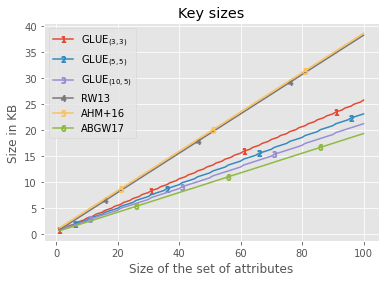

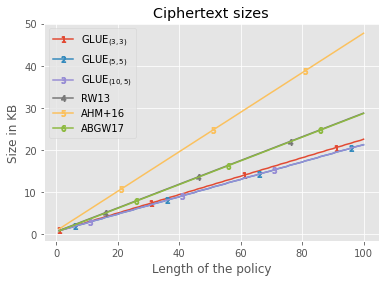

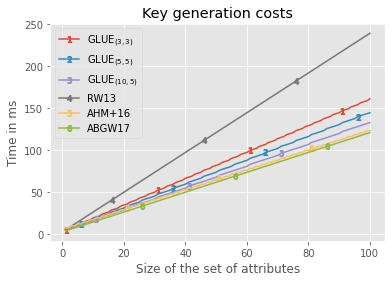

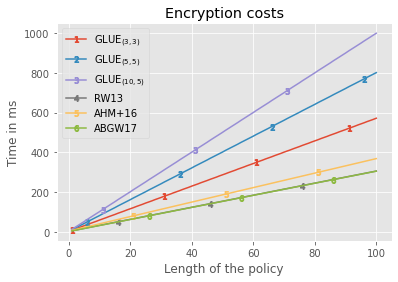

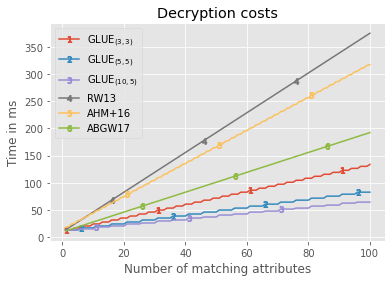

In [20]:
setmode('regular', False, 0)
plotall()

**Plots for online/offline schemes supporting MSPs only**

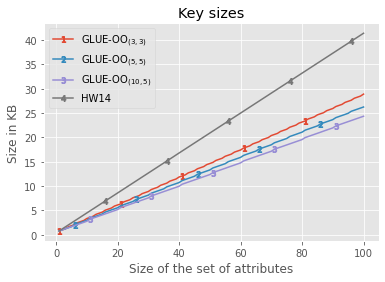

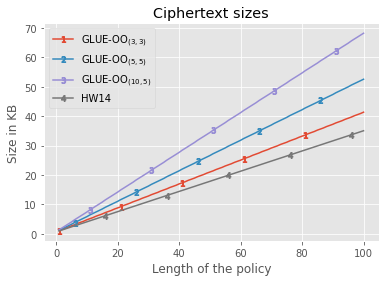

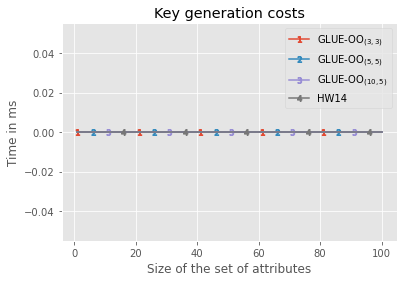

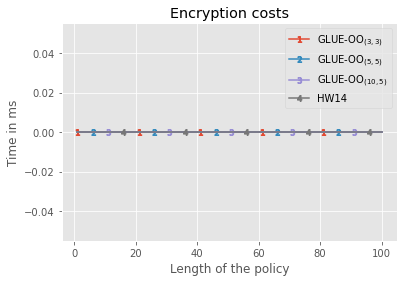

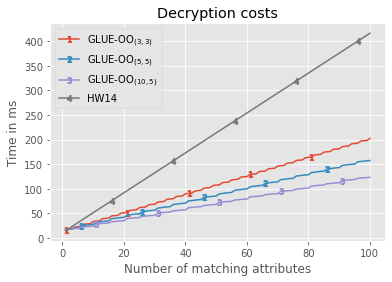

In [21]:
setmode('OO', False, 0)
plotall()

**Plots for regular schemes supporting NMSPs (non-negated policies)**

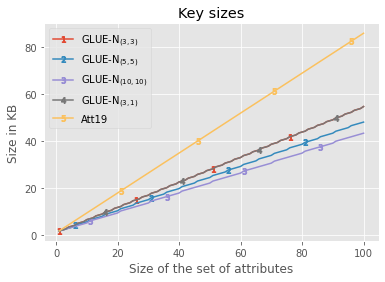

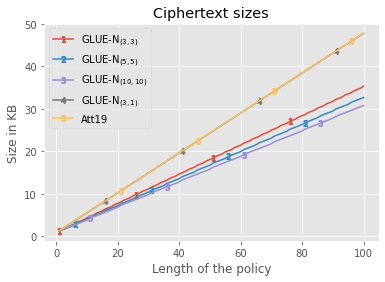

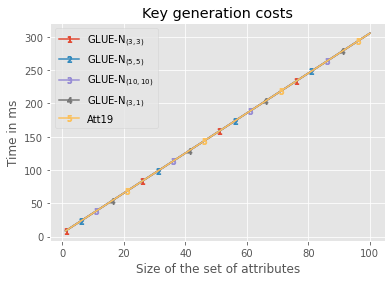

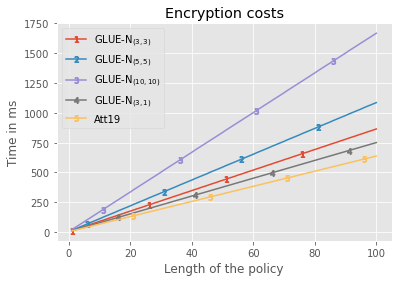

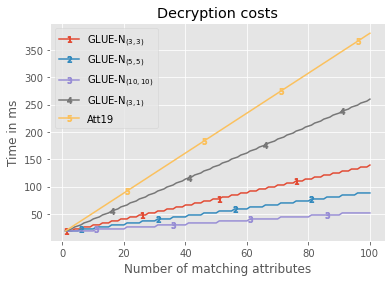

In [22]:
GLUEsettings = [(3,3), (5,5), (10,10), (3,1)]
setmode('N', False, 0)
plotall()

**Plots for regular schemes supporting NMSPs (negated policies, |S| = 1)**

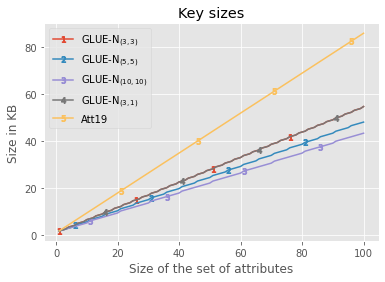

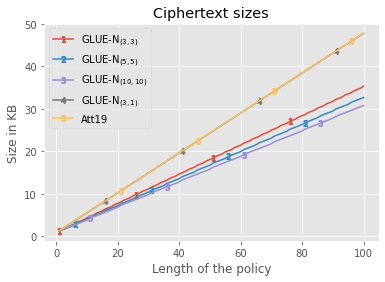

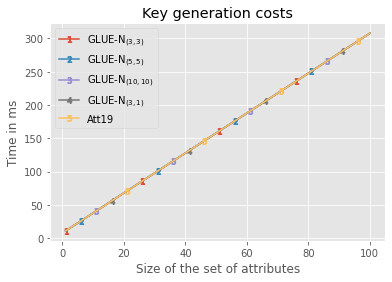

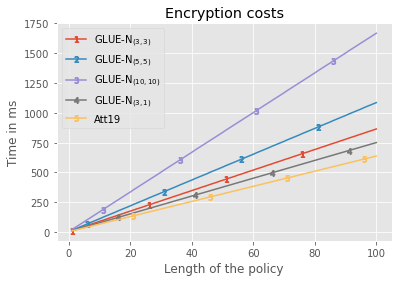

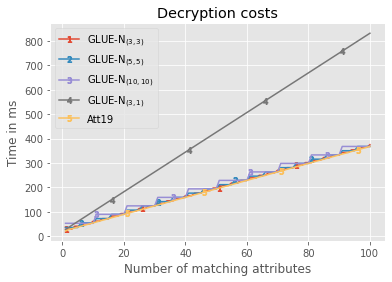

In [23]:
setmode('N', True, 1)
plotall()

**Plots for regular schemes supporting NMSPs (negated policies, |S| = 5)**

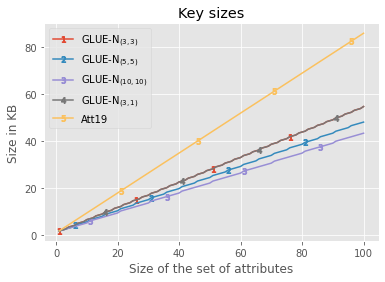

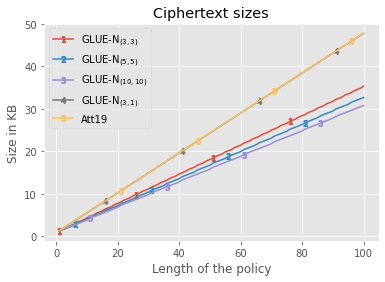

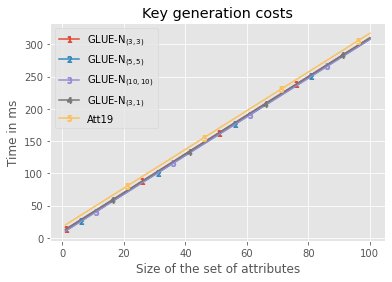

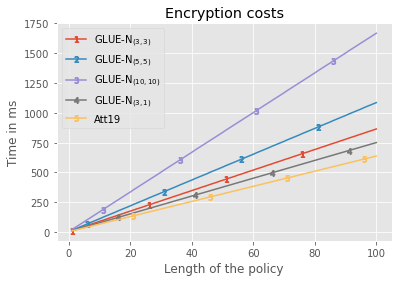

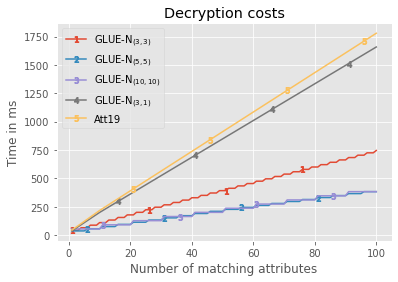

In [24]:
setmode('N', True, 5)
plotall()

**Plots for online/offline schemes supporting NMSPs (non-negated policies)**

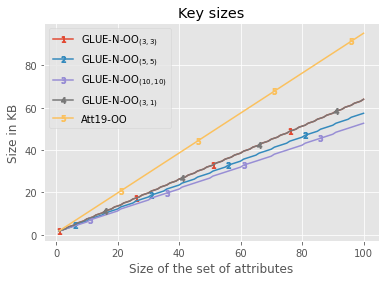

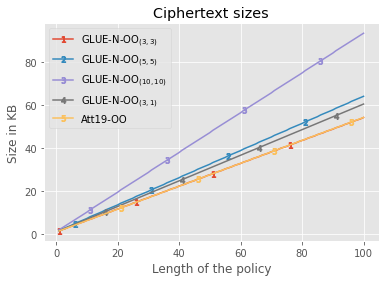

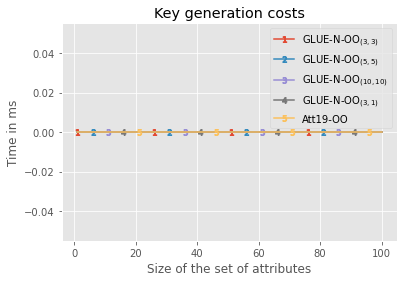

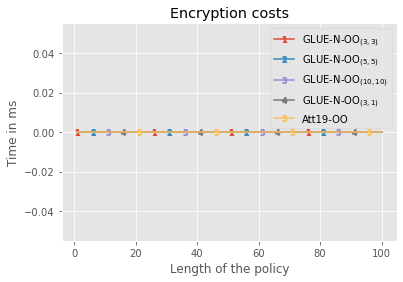

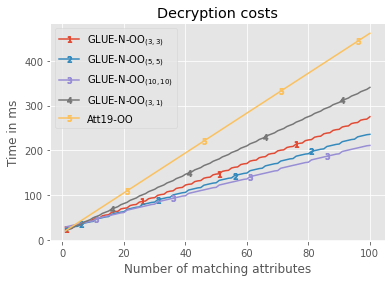

In [25]:
setmode('N-OO', False, 0)
plotall()

**Plots for online/offline schemes supporting NMSPs (negated policies, |S| = 1)**

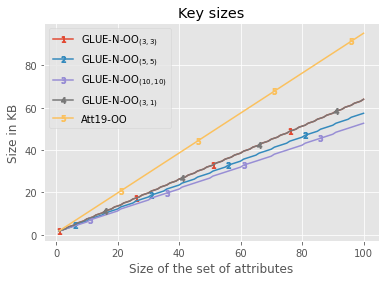

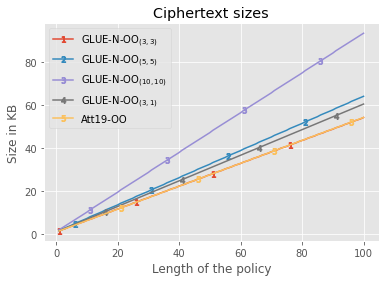

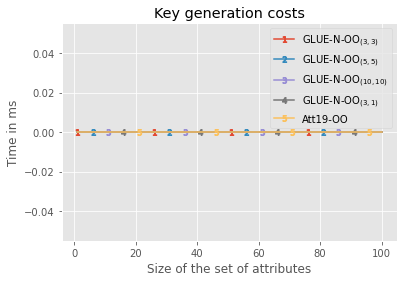

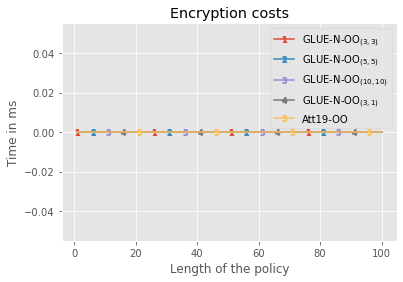

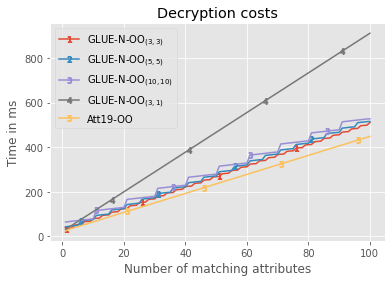

In [26]:
setmode('N-OO', True, 1)
plotall()

**Plots for online/offline schemes supporting NMSPs (negated policies, |S| = 5)**

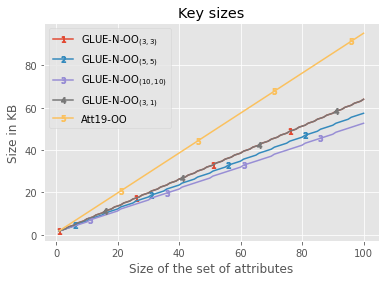

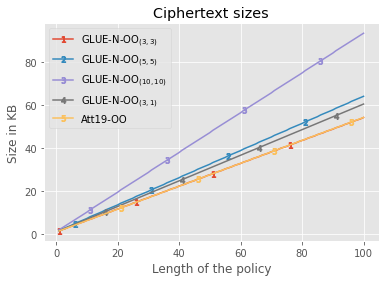

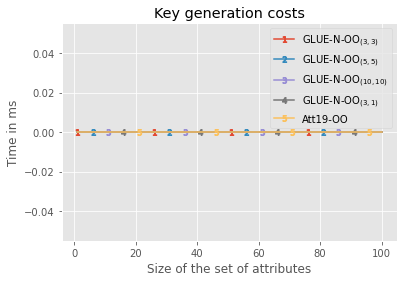

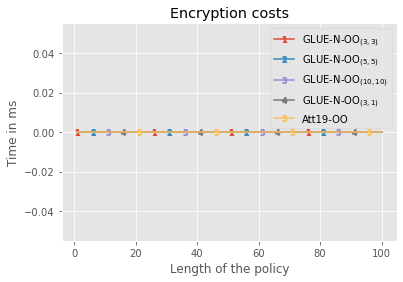

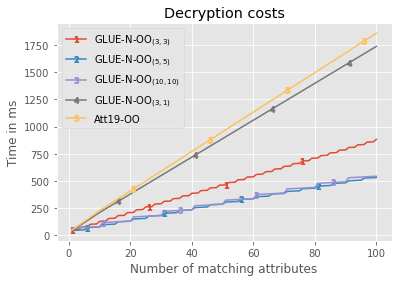

In [27]:
setmode('N-OO', True, 5)
plotall()

**Decryption costs for various GLUE settings**

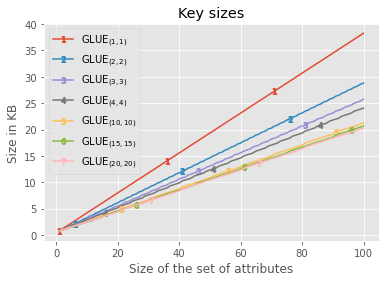

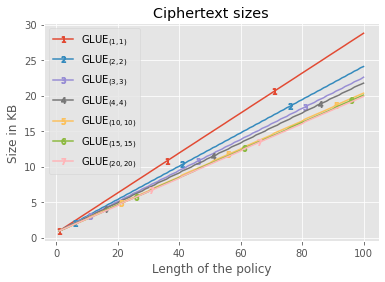

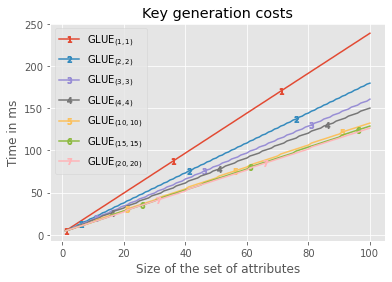

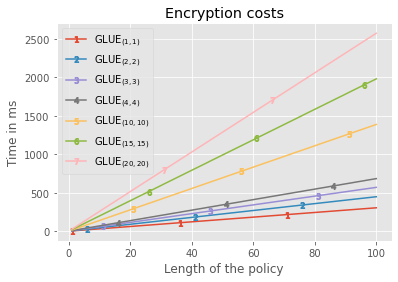

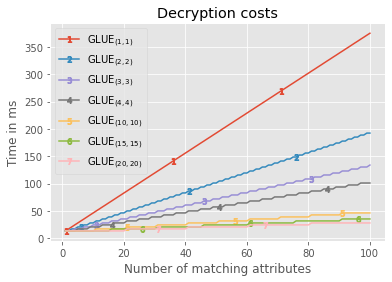

In [28]:
GLUEsettings = [(i,i) for i in range(1,5)] + [(10,10), (15,15), (20,20)]
setmode('regular', False, 0)
global suffix, nonregular
nonregular = True
suffix = '-manyGLUEs'

listoplot = []
plotall()

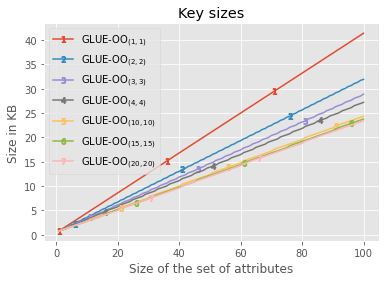

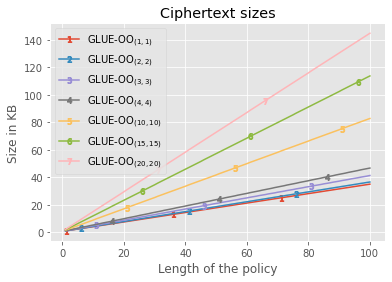

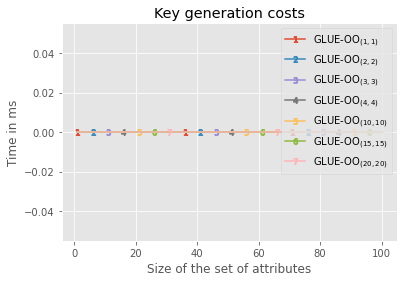

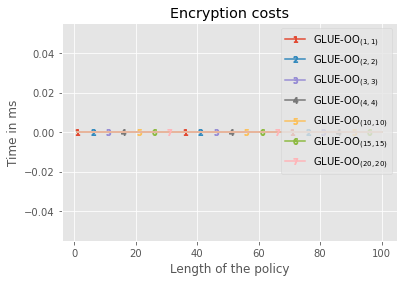

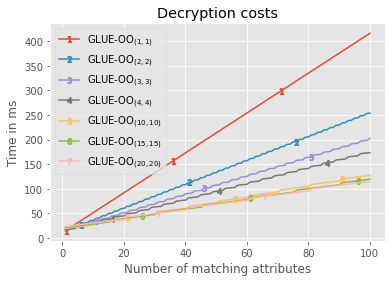

In [29]:
setmode('OO', False, 0)
global suffix, nonregular
nonregular = True
suffix = '-manyGLUEs'

listoplot = []
plotall()